In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import KFold

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, Callback
from keras.regularizers import L1, L2
from keras.initializers import RandomUniform, GlorotUniform, GlorotNormal, Initializer

import keras.backend as K 
import warnings

In [2]:
# load the dataset
from utils import read_cup
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [3]:
# Define metric MEE

def MEE_keras(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [4]:
# Define Fan-in weight initialization

class FanInInitializer(Initializer):
    def __init__(self, low, high):
        self.low = low
        self.high = high

    def __call__(self, shape, dtype=None):
        if len(shape) != 2:
            raise ValueError("FanInInitializer is only applicable to 2D weight tensors.")

        input_size, units_size = shape
        return K.constant(
            np.random.uniform(
                low=self.low, 
                high=self.high, 
                size=(input_size, units_size)
            ) * 2 / np.sqrt(input_size),
            dtype=dtype
        )

    def get_config(self):
        return {"low": self.low, "high": self.high}

## K-fold cross validation for our best NN

In [5]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (800, 10, 1)
y_train shape: (800, 3, 1)


In [6]:
# reshape X_train
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
print(f'X_train shape: {X_train.shape}')

# reshape y_train
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
print(f'y_train shape: {y_train.shape}')

X_train shape: (800, 10)
y_train shape: (800, 3)


Training on fold 1...
Epoch 1/3000
640/640 [==============================] - 0s 484us/step - loss: 86.0704 - MEE_keras: 9.9397 - val_loss: 6.8386 - val_MEE_keras: 3.9647
Epoch 2/3000
640/640 [==============================] - 0s 414us/step - loss: 5.4623 - MEE_keras: 3.4374 - val_loss: 3.9679 - val_MEE_keras: 3.0429
Epoch 3/3000
640/640 [==============================] - 0s 480us/step - loss: 3.2468 - MEE_keras: 2.6326 - val_loss: 2.2898 - val_MEE_keras: 2.1665
Epoch 4/3000
640/640 [==============================] - 0s 406us/step - loss: 2.3714 - MEE_keras: 2.2847 - val_loss: 3.0804 - val_MEE_keras: 2.6845
Epoch 5/3000
640/640 [==============================] - 0s 407us/step - loss: 1.8905 - MEE_keras: 2.0601 - val_loss: 2.0148 - val_MEE_keras: 2.1747
Epoch 6/3000
640/640 [==============================] - 0s 466us/step - loss: 1.6259 - MEE_keras: 1.9308 - val_loss: 2.0409 - val_MEE_keras: 2.0711
Epoch 7/3000
640/640 [==============================] - 0s 428us/step - loss: 1.5618 - ME

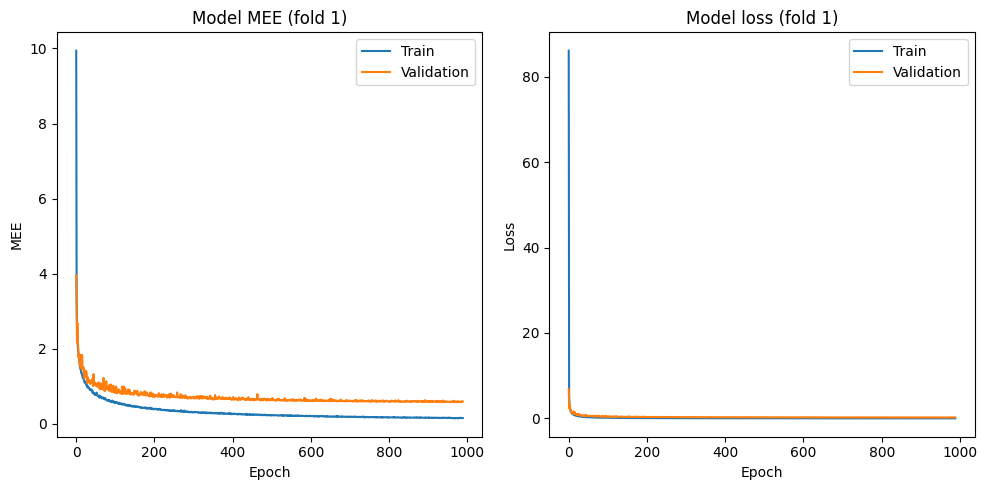

Training on fold 2...
Epoch 1/3000
640/640 [==============================] - 1s 632us/step - loss: 89.3573 - MEE_keras: 9.8217 - val_loss: 8.2910 - val_MEE_keras: 4.1545
Epoch 2/3000
640/640 [==============================] - 0s 565us/step - loss: 4.5394 - MEE_keras: 3.1151 - val_loss: 2.9224 - val_MEE_keras: 2.3688
Epoch 3/3000
640/640 [==============================] - 0s 594us/step - loss: 2.9843 - MEE_keras: 2.5467 - val_loss: 6.3196 - val_MEE_keras: 3.4973
Epoch 4/3000
640/640 [==============================] - 0s 566us/step - loss: 2.6341 - MEE_keras: 2.4065 - val_loss: 1.8642 - val_MEE_keras: 2.0108
Epoch 5/3000
640/640 [==============================] - 0s 647us/step - loss: 2.0438 - MEE_keras: 2.1249 - val_loss: 2.3766 - val_MEE_keras: 2.2487
Epoch 6/3000
640/640 [==============================] - 1s 834us/step - loss: 1.8089 - MEE_keras: 2.0227 - val_loss: 1.9051 - val_MEE_keras: 1.9966
Epoch 7/3000
640/640 [==============================] - 1s 824us/step - loss: 1.5489 - ME

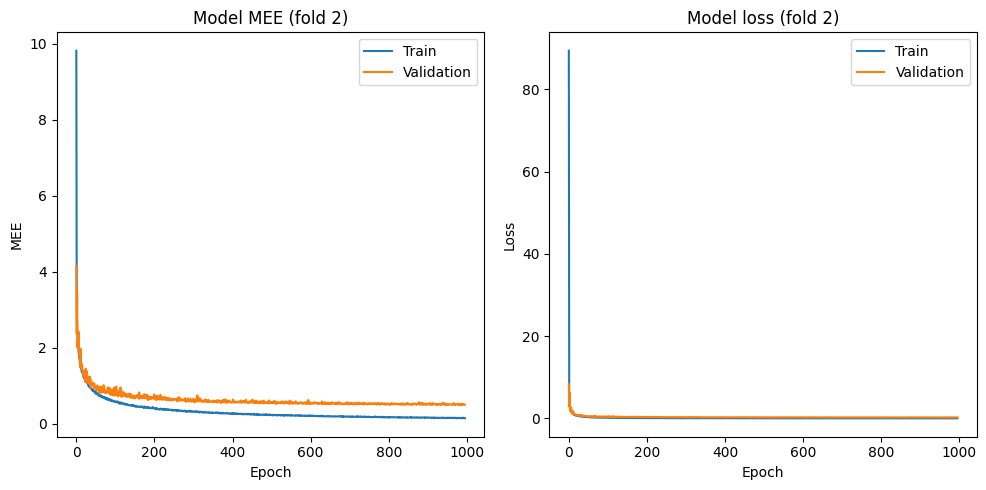

Training on fold 3...


Epoch 1/3000
640/640 [==============================] - 1s 554us/step - loss: 93.7314 - MEE_keras: 10.4581 - val_loss: 8.4496 - val_MEE_keras: 4.4149
Epoch 2/3000
640/640 [==============================] - 0s 431us/step - loss: 5.1908 - MEE_keras: 3.3461 - val_loss: 4.6335 - val_MEE_keras: 3.2188
Epoch 3/3000
640/640 [==============================] - 0s 445us/step - loss: 3.1615 - MEE_keras: 2.5980 - val_loss: 2.4225 - val_MEE_keras: 2.2774
Epoch 4/3000
640/640 [==============================] - 0s 508us/step - loss: 2.6561 - MEE_keras: 2.4201 - val_loss: 3.1916 - val_MEE_keras: 2.8203
Epoch 5/3000
640/640 [==============================] - 0s 466us/step - loss: 1.9071 - MEE_keras: 2.0761 - val_loss: 1.7036 - val_MEE_keras: 1.9095
Epoch 6/3000
640/640 [==============================] - 0s 430us/step - loss: 1.7237 - MEE_keras: 1.9401 - val_loss: 2.2915 - val_MEE_keras: 2.2993
Epoch 7/3000
640/640 [==============================] - 0s 424us/step - loss: 1.5711 - MEE_keras: 1.8510 - val

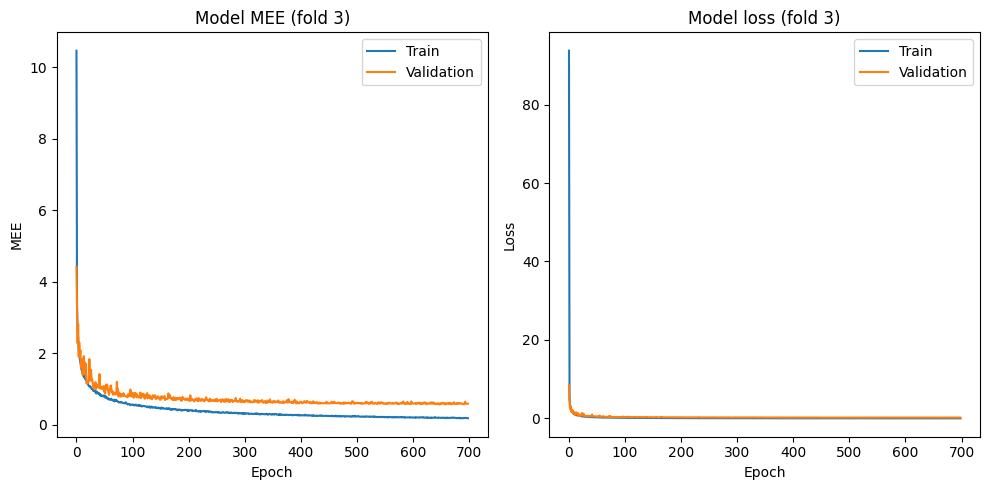

Training on fold 4...
Epoch 1/3000
640/640 [==============================] - 0s 558us/step - loss: 98.0040 - MEE_keras: 10.3383 - val_loss: 7.8364 - val_MEE_keras: 4.2849
Epoch 2/3000
640/640 [==============================] - 0s 423us/step - loss: 4.9122 - MEE_keras: 3.2483 - val_loss: 3.1958 - val_MEE_keras: 2.6470
Epoch 3/3000
640/640 [==============================] - 0s 412us/step - loss: 2.9203 - MEE_keras: 2.5196 - val_loss: 2.3336 - val_MEE_keras: 2.1880
Epoch 4/3000
640/640 [==============================] - 0s 437us/step - loss: 2.2482 - MEE_keras: 2.2196 - val_loss: 2.0803 - val_MEE_keras: 2.0609
Epoch 5/3000
640/640 [==============================] - 0s 437us/step - loss: 1.8100 - MEE_keras: 2.0082 - val_loss: 1.9933 - val_MEE_keras: 2.0639
Epoch 6/3000
640/640 [==============================] - 0s 510us/step - loss: 1.5640 - MEE_keras: 1.8505 - val_loss: 1.7380 - val_MEE_keras: 1.9780
Epoch 7/3000
640/640 [==============================] - 0s 445us/step - loss: 1.4471 - M

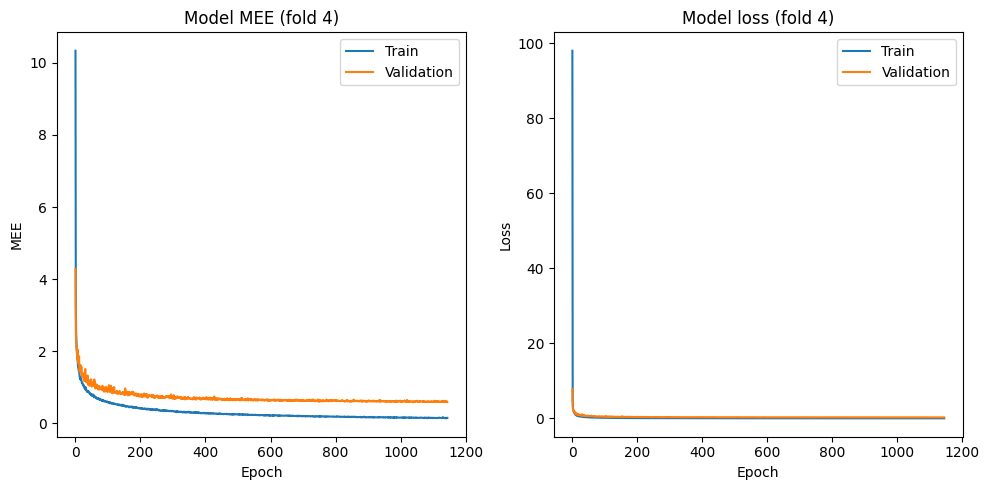

Training on fold 5...
Epoch 1/3000
640/640 [==============================] - 0s 489us/step - loss: 91.5378 - MEE_keras: 10.1579 - val_loss: 6.6224 - val_MEE_keras: 3.8218
Epoch 2/3000
640/640 [==============================] - 0s 421us/step - loss: 4.9911 - MEE_keras: 3.3191 - val_loss: 5.9086 - val_MEE_keras: 3.7952
Epoch 3/3000
640/640 [==============================] - 0s 418us/step - loss: 3.1827 - MEE_keras: 2.6571 - val_loss: 2.1915 - val_MEE_keras: 2.1804
Epoch 4/3000
640/640 [==============================] - 0s 421us/step - loss: 2.4491 - MEE_keras: 2.3073 - val_loss: 2.1374 - val_MEE_keras: 2.1376
Epoch 5/3000
640/640 [==============================] - 0s 415us/step - loss: 2.0752 - MEE_keras: 2.1279 - val_loss: 1.3574 - val_MEE_keras: 1.7465
Epoch 6/3000
640/640 [==============================] - 0s 418us/step - loss: 1.7094 - MEE_keras: 1.9673 - val_loss: 1.3947 - val_MEE_keras: 1.7451
Epoch 7/3000
640/640 [==============================] - 0s 417us/step - loss: 1.5793 - M

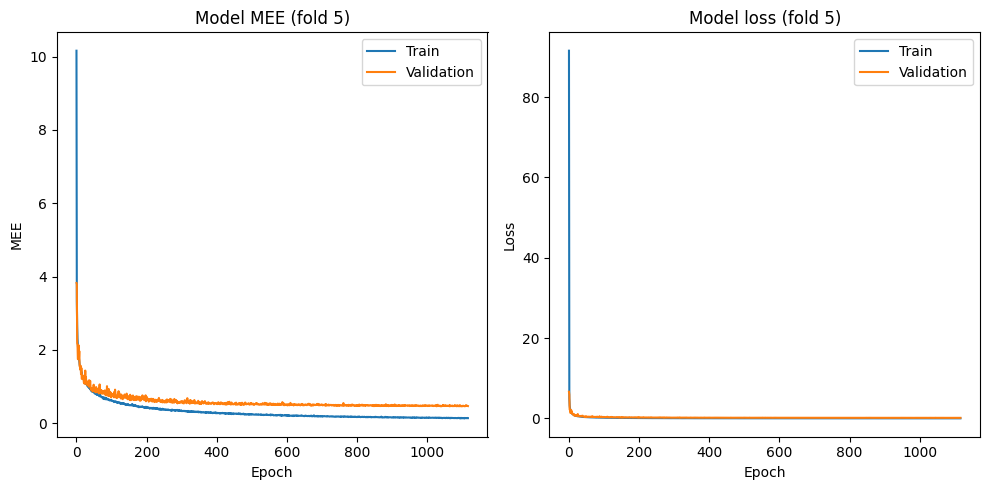

In [7]:
# Define the number of folds
n_splits = 5

# Keep in a list MEE_keras and val_MEE_keras values for each fold
MEE_keras_list = []
val_MEE_keras_list = []

# Initialize StratifiedKFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate through the folds
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    print(f"Training on fold {fold + 1}...")
    
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = Sequential()
    model.add(
        Dense(
            units=512, 
            input_dim=X_train.shape[1], 
            activation='relu', 
            kernel_regularizer=L2(1e-8), 
            kernel_initializer=FanInInitializer(low=-0.5, high=0.5)
        )
    )
    model.add(
        Dense(
            units=128, 
            activation='relu', 
            kernel_regularizer=L2(1e-8), 
            kernel_initializer=FanInInitializer(low=-0.5, high=0.5)
        )
    )
    model.add(
        Dense(
            units=3, 
            activation='linear', 
            kernel_regularizer=L2(1e-8), 
            kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05, seed=6)
        )
    )
    
    # Compile and train the model on the current fold
    model.compile(
        optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), 
        loss='MSE', 
        metrics=[MEE_keras]
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        min_delta=0.01,
        patience=250, 
        restore_best_weights=True 
    )
    
    history = model.fit(
        X_train_fold, 
        y_train_fold, 
        epochs=3000, 
        batch_size=1, 
        validation_data=(X_val_fold, y_val_fold), 
        callbacks=[early_stopping]
    )
    
    MEE_keras_list.append(history.history['MEE_keras'][-250])
    val_MEE_keras_list.append(history.history['val_MEE_keras'][-250])
    
    history = history.history

    # plot training and validation mee values
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history['MEE_keras'])
    plt.plot(history['val_MEE_keras'])
    plt.title('Model MEE (fold {})'.format(fold + 1))
    plt.ylabel('MEE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss (fold {})'.format(fold + 1))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Calculate the mean of MEE_keras_list and val_MEE_keras_list 
MEE_keras_mean = np.mean(MEE_keras_list)
val_MEE_keras_mean = np.mean(val_MEE_keras_list)

print(f'Mean MEE_keras over the 5 folds: {MEE_keras_mean:.4f}')
print(f'Mean val_MEE_keras over the 5 folds: {val_MEE_keras_mean:.4f}')

Mean MEE_keras over the 5 folds: 0.1895
Mean val_MEE_keras over the 5 folds: 0.5623


We retrain the model on X_train (80% of dataset), and test it on our internal test set: X_test (20% of dataset). We decided to train the model for 989 epochs, which is the mean of the number of epochs of the 5 folds.

Epoch 1/989
800/800 [==============================] - 1s 472us/step - loss: 72.9418 - MEE_keras: 8.8019 - val_loss: 4.7514 - val_MEE_keras: 3.3442
Epoch 2/989
800/800 [==============================] - 0s 420us/step - loss: 4.0372 - MEE_keras: 2.9418 - val_loss: 3.4145 - val_MEE_keras: 2.7620
Epoch 3/989
800/800 [==============================] - 0s 439us/step - loss: 2.4150 - MEE_keras: 2.3209 - val_loss: 1.9690 - val_MEE_keras: 2.1447
Epoch 4/989
800/800 [==============================] - 0s 431us/step - loss: 1.9252 - MEE_keras: 2.0606 - val_loss: 2.7604 - val_MEE_keras: 2.3848
Epoch 5/989
800/800 [==============================] - 0s 435us/step - loss: 1.6229 - MEE_keras: 1.8802 - val_loss: 1.6839 - val_MEE_keras: 1.8783
Epoch 6/989
800/800 [==============================] - 0s 420us/step - loss: 1.3963 - MEE_keras: 1.7422 - val_loss: 1.4776 - val_MEE_keras: 1.7821
Epoch 7/989
800/800 [==============================] - 0s 405us/step - loss: 1.3442 - MEE_keras: 1.7129 - val_loss: 1

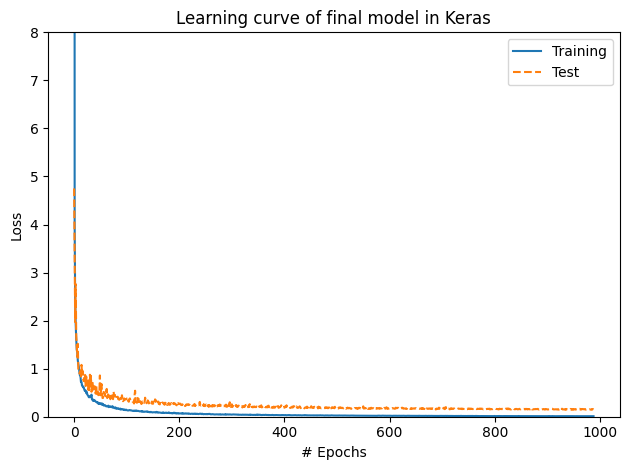

7/7 [==============================] - 0s 898us/step - loss: 0.1516 - MEE_keras: 0.4768
Test Loss: 0.1516
Test MEE: 0.4768


In [7]:
model = Sequential()
model.add(
    Dense(
        units=512, 
        input_dim=X_train.shape[1], 
        activation='relu', 
        kernel_regularizer=L2(1e-8), 
        kernel_initializer=FanInInitializer(low=-0.5, high=0.5)
    )
)
model.add(
    Dense(
        units=128, 
        activation='relu', 
        kernel_regularizer=L2(1e-8), 
        kernel_initializer=FanInInitializer(low=-0.5, high=0.5)
    )
)
model.add(
    Dense(
        units=3, 
        activation='linear', 
        kernel_regularizer=L2(1e-8), 
        kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05, seed=6)
    )
)
    
# Compile and train the model on the current fold
model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), 
    loss='MSE', 
    metrics=[MEE_keras]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=989, 
    batch_size=1,
    validation_data=(X_test, y_test)
)

history = history.history

"""
# plot training and validation mee values
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history['MEE_keras'])
plt.plot(history['val_MEE_keras'], linestyle='--')
plt.title('Model MEE')
plt.ylabel('MEE')
plt.xlabel('# Epochs')
plt.legend(['Training', 'Test'], loc='upper right')
"""

# plot training and validation loss values
#plt.subplot(1, 2, 2)
plt.ylim(0, 8)
plt.plot(history['loss'])
plt.plot(history['val_loss'], linestyle='--')
plt.title('Learning curve of final model in Keras')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['Training', 'Test'], loc='upper right')

plt.tight_layout()
plt.savefig('../plots/final_model_keras.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate the model on the test set
loss, MEE_keras = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test MEE: {MEE_keras:.4f}')